# Imports

In [66]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Loading the Split Dataframes

In [20]:
df_train = pd.read_csv('dataset/csvs/train_df.csv')
df_val = pd.read_csv('dataset/csvs/val_df.csv')
df_test = pd.read_csv('dataset/csvs/test_df.csv')

# Class Distribution of Training Data 

In [23]:
df_train.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,3231,58,Female,3231_left.jpg,3231_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3231_left.jpg
1,3960,55,Male,3960_left.jpg,3960_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",3960_left.jpg
2,1657,50,Female,1657_left.jpg,1657_right.jpg,lens dust，pathological myopia,mild nonproliferative retinopathy,0,1,0,0,0,0,1,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",1657_right.jpg
3,277,75,Male,277_left.jpg,277_right.jpg,normal fundus,drusen,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",277_left.jpg
4,364,45,Male,364_left.jpg,364_right.jpg,myelinated nerve fibers,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",364_left.jpg


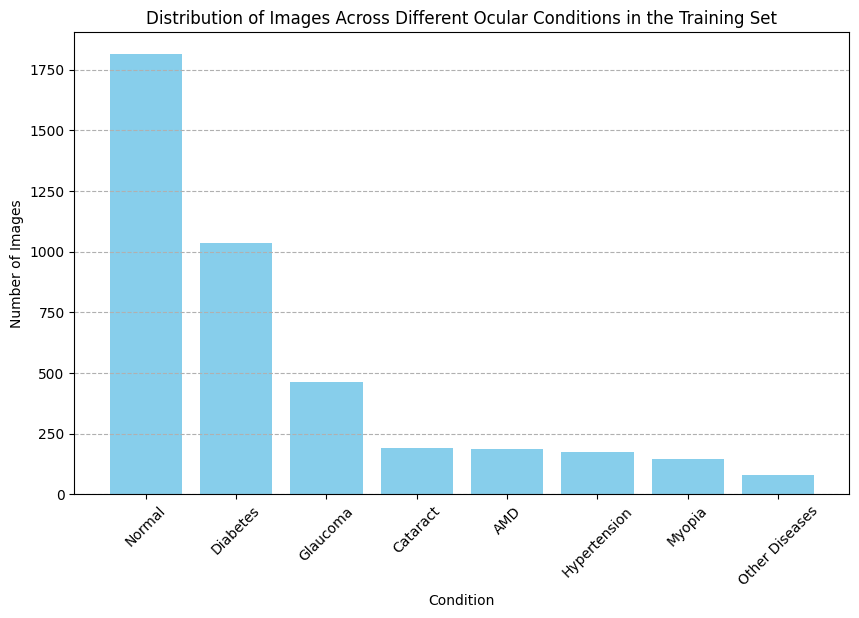

{'Normal': 1814,
 'Diabetes': 1035,
 'Glaucoma': 463,
 'Cataract': 190,
 'AMD': 188,
 'Hypertension': 174,
 'Myopia': 147,
 'Other Diseases': 79}

In [21]:
# Sum up all the target lists to get the class distribution
class_distribution = df_train['target'].value_counts()

# Assuming class_labels are in the correct order as per your earlier description
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other Diseases']

# Map the distribution counts to the class labels
class_distribution_dict = dict(zip(class_labels, class_distribution))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_distribution_dict.keys(), class_distribution_dict.values(), color='skyblue')
plt.title('Distribution of Images Across Different Ocular Conditions in the Training Set')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

# Show the plot
plt.show()

# Also, return the class distribution for detailed examination
class_distribution_dict

# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class by first calculating the augmentations required per class. Augmentation to only the training data will be applied. 
- The following minority classes should have their class sizes balanced -  D(Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

Calculating Augmentations needed per class

In [22]:
# Assuming 'class_distribution' is a dictionary with your class labels and counts
target_sample_count = max(class_distribution_dict.values())  # or set a custom target

augmentations_needed = {
    class_label: target_sample_count - count 
    for class_label, count in class_distribution_dict.items() if count < target_sample_count
}

# Calculate the number of augmentations needed per existing sample
augmentations_per_sample = {
    class_label: (augmentations_needed[class_label] // count) + 1  # Adding 1 for at least one augmentation
    for class_label, count in class_distribution_dict.items() if class_label in augmentations_needed
}

print(augmentations_per_sample)

{'Diabetes': 1, 'Glaucoma': 3, 'Cataract': 9, 'AMD': 9, 'Hypertension': 10, 'Myopia': 12, 'Other Diseases': 22}


Augmentations

In [ ]:
augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [54]:
augmentation_times = {0:0, 1: 1, 2: 3, 3: 9, 4: 9, 5: 10, 6: 12, 7: 22}

# Preparing the Data 

In [56]:
# Function to load and preprocess images
def parse_image_and_label(image_path, label_string):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing the image to be compatible with ResNet50
    # Assuming label_string is the string representation of the list (e.g., "[1, 0, 0]")
    label = tf.strings.substr(label_string, 1, tf.strings.length(label_string) - 2)  # Remove brackets
    label = tf.strings.to_number(tf.strings.split(label, ','), out_type=tf.float32)
    return image, label

In [67]:

augmenter = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmentation_times = {0:0, 1: 1, 2: 3, 3: 9, 4: 9, 5: 10, 6: 12, 7: 22}

def augment_and_save_image(row, save_directory, augmentation, augmentations_needed):
    img_path = os.path.join('dataset/preprocessed_images', row['filename'])
    img = load_img(img_path)
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)

    augmented_rows = []

    # Assuming 'target' is a single label. Adjust if 'target' is more complex.
    max_augmentations_needed = augmentations_needed[row['target']]

    # Save the original image to the new directory with a prefix
    original_filename = f"original_{row['filename']}"
    img.save(os.path.join(save_directory, original_filename))

    # Add original image row
    augmented_rows.append({**row, 'filename': original_filename})

    # Generate augmented images
    for i in range(max_augmentations_needed):
        augmented_img = next(augmentation.flow(x, batch_size=1))[0]
        augmented_img = Image.fromarray(np.uint8(augmented_img))
        unique_filename = f'aug_{i}_{row["filename"]}'
        augmented_img.save(os.path.join(save_directory, unique_filename))

        # Add augmented image row
        augmented_rows.append({**row, 'filename': unique_filename})
    
    return augmented_rows



In [68]:
save_directory = 'dataset/augmented_images'
os.makedirs(save_directory, exist_ok=True)

augmented_data = []

with ThreadPoolExecutor(max_workers=4) as executor:
    tasks = [executor.submit(augment_and_save_image, row, save_directory, augmentation, augmentations_needed)
             for _, row in df_train.iterrows()]

    for future in tqdm(as_completed(tasks), total=len(tasks), desc="Augmenting Images"):
        augmented_data.extend(future.result())

# Convert augmented data to DataFrame and save
df_augmented = pd.DataFrame(augmented_data)
df_augmented.to_csv('dataset/augmented_train.csv', index=False)


NameError: name 'save_directory' is not defined

In [58]:
def load_and_prepare_dataset(df, images_dir, shuffle=True, batch_size=32):
    # Assuming images_dir is the base directory for the images and concatenating it with image filenames
    images_left = images_dir + df['Left-Fundus']
    images_right = images_dir + df['Right-Fundus']

    # Assuming 'target' column contains labels in a string format that needs to be parsed
    labels_left = df['target'].values
    labels_right = df['target'].values

    # Combine the left and right images and labels
    filenames = np.concatenate([images_left, images_right])
    labels = np.concatenate([labels_left, labels_right])

    # Creating TensorFlow dataset
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(parse_image_and_label)  # Apply the preprocessing function
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    return dataset


In [65]:
train_ds = load_and_augment_dataset(df_train, 'dataset/ODIR-5K/Training Images/', augmentation_times, shuffle=True, batch_size=16)
val_ds = load_and_prepare_dataset(df_val, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)
test_ds = load_and_prepare_dataset(df_test, 'dataset/ODIR-5K/Training Images/', shuffle=False, batch_size=16)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type tensorflow.python.framework.ops.EagerTensor).

In [11]:
print("size of training dataset: ", train_ds.cardinality().numpy())
print("size of validation dataset: ", val_ds.cardinality().numpy())
print("size of test dataset: ", test_ds.cardinality().numpy())

size of training dataset:  512
size of validation dataset:  128
size of test dataset:  160


# Loading and Visualising the Training Data 

Training dataset
(16, 224, 224, 3)
(16, 8)


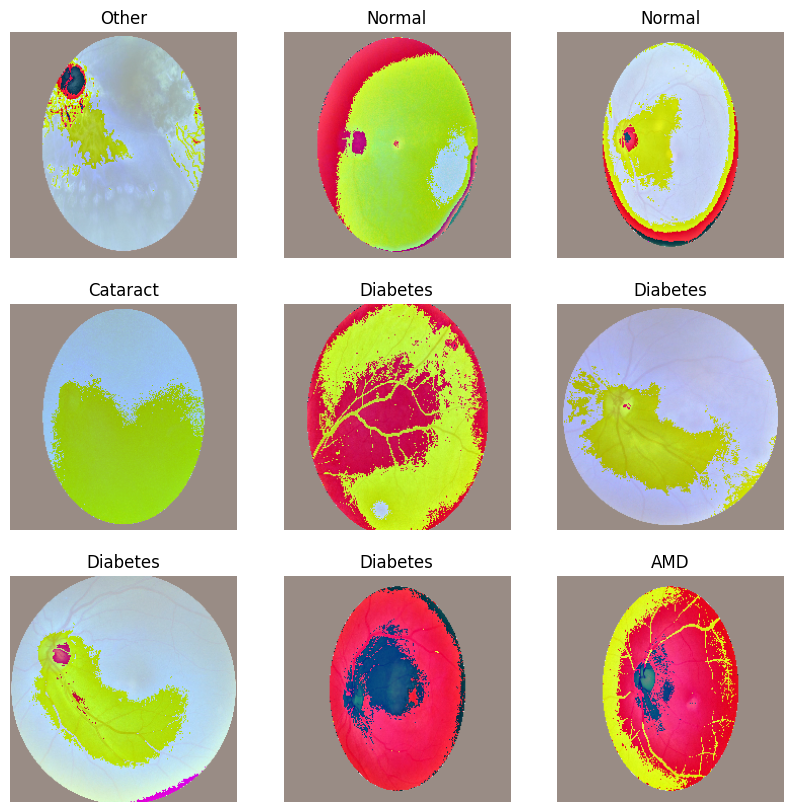

In [12]:
print("Training dataset")
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])

    plt.axis("off")


Validation dataset
(16, 224, 224, 3)
(16, 8)


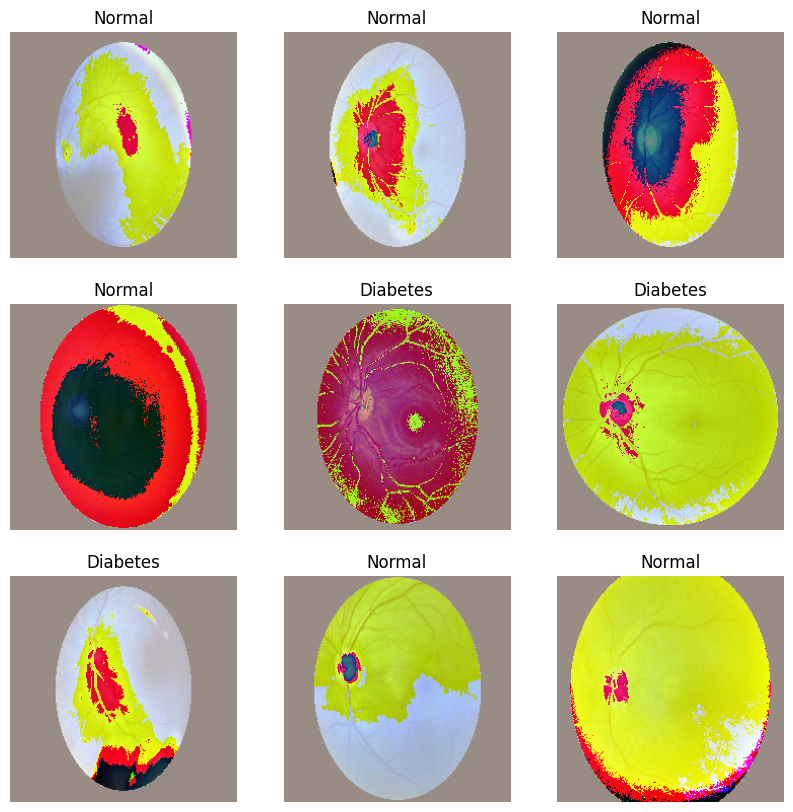

In [13]:
print("Validation dataset")
for images, labels in val_ds.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_names = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
    class_index = np.argmax(labels[i].numpy())
    plt.title(class_names[class_index])
    plt.axis("off")

# Training the model

- A BatchNormalization layer and a Dropout layer are added immediately after flattening the output of the pretrained ResNet50 base. A Dense layer with both L1 and L2 regularization follows the Dropout layer. The regularization helps prevent overfitting by adding a penalty for larger weights, and Dropout randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Batch Normalization normalizes the inputs heading into the next layer, which ensures that the network always creates activations with the same distribution that we desire.

In [14]:
# Setup Callbacks

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

# Checkpoint callback
checkpoint_filepath = 'Best_Model_Resnet50.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [15]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))

In [16]:
resnet_50_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
epochs =  50
history = resnet_50_model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


261/512 [==============>...............] - ETA: 24s - loss: 1.3830 - accuracy: 0.4773

# Evaluating Model 

Model Accuracy Graph Analysis

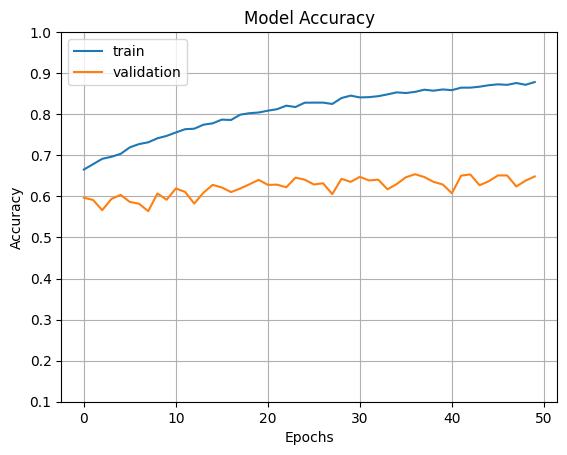

In [49]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.1,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Model Loss Graph Analysis 

In [2]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
test_ds.take(1)

# Evaluating the model on the test set
loss, accuracy = resnet_50_model.evaluate(test_ds)
print(f'Test accuracy: {round(accuracy * 100, 2)}%')


# Making Predictions

160/160 [==============================] - 11s 65ms/step - loss: 1.4061 - accuracy: 0.6126
Evaluation results: [1.4061354398727417, 0.6125879883766174]
160/160 [==============================] - 10s 62ms/step


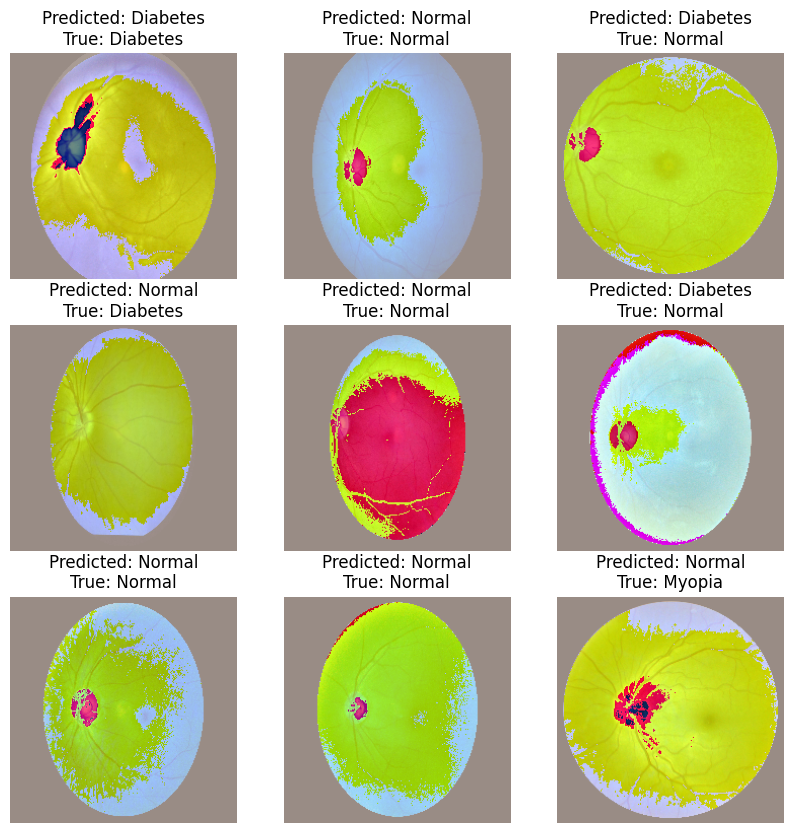

In [61]:
# Evaluate the model on the test dataset
evaluation_results = resnet_50_model.evaluate(test_ds)
print("Evaluation results:", evaluation_results)

# Generate predictions
predictions = resnet_50_model.predict(test_ds)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# To plot the images with the predicted and true labels, you would have to iterate over the test dataset and plot each image
# However, test_ds contains batches of images, so you need to unbatch it first to access individual images

# Define the number of images you want to display
num_images_to_display = 9

# Initialize lists to store the images and labels
display_images = []
display_labels = []

# Iterate over the dataset to collect images and labels
for images, labels in test_ds.unbatch().take(num_images_to_display):
    display_images.append(images)
    display_labels.append(labels)

# Now plot the images with predictions and true labels
plt.figure(figsize=(10, 10))
for i, image in enumerate(display_images):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    true_label = class_labels[np.argmax(display_labels[i].numpy())]
    predicted_label = class_labels[predicted_classes[i]]
    plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
    plt.axis("off")
plt.show()


# Predictions Result Evaluation

In [62]:
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_auc_score

Classification Report 

In [75]:
# Let's check the shape of the unbatched labels
for _, label in test_ds.unbatch().take(1):
    print("Unbatched label shape:", label.numpy().shape)


Unbatched label shape: (8,)


In [76]:
# Collect the true labels from the unbatched dataset
true_labels = np.vstack([y.numpy() for _, y in test_ds.unbatch()])

# true_labels should now be a 2-dimensional array, you can verify by printing its shape
print("Shape of true_labels after vstack:", true_labels.shape)

# Convert one-hot encoded labels to class indices
true_classes = np.argmax(true_labels, axis=1)

Shape of true_labels after vstack: (2558, 8)


In [77]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other diseases']

# Now, the number of predicted classes should match the number of true classes
# Generate the classification report again
report = classification_report(true_classes, predicted_classes, target_names=class_labels, zero_division=0)

print(report)


                precision    recall  f1-score   support

        Normal       0.64      0.76      0.69      1138
      Diabetes       0.67      0.50      0.57       666
      Glaucoma       0.64      0.56      0.59       122
      Cataract       0.59      0.64      0.61       116
           AMD       0.73      0.51      0.60        92
  Hypertension       0.72      0.64      0.68        56
        Myopia       0.78      0.76      0.77        96
Other diseases       0.26      0.25      0.26       272

      accuracy                           0.61      2558
     macro avg       0.63      0.58      0.60      2558
  weighted avg       0.61      0.61      0.61      2558



Balanced Accuracy Score 

In [78]:
balanced_accuracy = balanced_accuracy_score(true_classes, predicted_classes)
print('Balanced Accuracy: {:.4f}'.format(balanced_accuracy))

Balanced Accuracy: 0.5778


Area Under the Reciever Operating Characteristic Curve (AUC-ROC)

In [79]:
from keras.utils import to_categorical
true_classes_one_hot = to_categorical(true_classes, num_classes=8)

# Calculate ROC AUC for multi-class classification
roc_auc = roc_auc_score(true_classes_one_hot, predictions, average='macro', multi_class='ovo')

print(f'ROC AUC: {roc_auc:.4f}')

ROC AUC: 0.8501


Confusion Matrix 

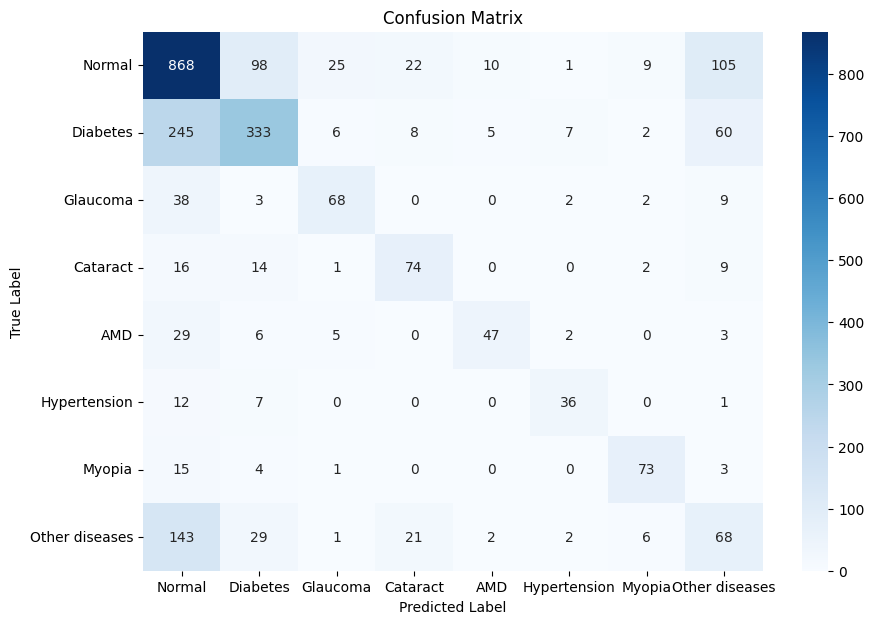

In [80]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Prediction Evaluation

In [ ]:
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

# Function to get top 3 indices for all predictions
def get_top3_indices(predictions):
    return predictions.argsort()[:, -3:]

# Count the frequency of each class being in the top 3
top3_indices = get_top3_indices(predictions)
class_counts = np.zeros(len(class_labels))

for indices in top3_indices:
    for index in indices:
        class_counts[index] += 1



# Plotting
plt.figure(figsize=(10, 6))
plt.bar(class_labels, class_counts)
plt.xlabel('Class')
plt.ylabel('Frequency in Top 3 Predictions')
plt.title('Frequency of Each Class in Top 3 Predictions Across All Instances')
plt.xticks(rotation=45)
plt.show()